<a href="https://colab.research.google.com/github/sarashahin/Badger_AI/blob/main/KeyPoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'project-ai:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4881695%2F8522226%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T112430Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D79be577259021aab2c8a55854f982a3acca900750450f01293b6ddca1469a1cb3f9c2b79dc033c2363ea8173abe5434fc3360052a6a8315859e49f91096c7e460fd05babc974a1752067c908b3e39609adb12af1215537af6593fa81970642a924680a7893d7d7b5ffd0c70f00fdf27bd76c52693c5fd9cdbf6980ba7a8b01ead8304021ec716a57f135da7035f117fcafc981d5cec189ded8af65cda2057ad203d26e1a93ec721c21d9c3aa1f1f99dcf17b1697b2ba50736c6d5167bd3db26562f39abd0ee85dc4a50bbdfc9dece35e520e2b1585e2a0f3da1b66a8b5b7beda30fa1dc0791e9db21e9b577734e398fcb488ad981d72a1aaccd40c5ed6c95881'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Helper function to draw bounding boxes
def draw_bounding_box(image, bbox, label, color=(255, 0, 0)):
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import json
import matplotlib.pyplot as plt

# extract and save keypoints using SIFT
def extract_and_save_keypoints_sift(image_path, annotation_path, output_dir):
    # Load image
    image = cv2.imread(image_path)

    # Parse XML annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    image_keypoints = {}

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        ymin = int(xmlbox.find('ymin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymax = int(xmlbox.find('ymax').text)

        # Extract region
        roi = image[ymin:ymax, xmin:xmax]

        # Keypoint detection
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(roi, None)

        # Convert keypoints to a list of tuples
        keypoints_list = [(kp.pt[0] + xmin, kp.pt[1] + ymin, kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in keypoints]
        descriptors_list = descriptors.tolist() if descriptors is not None else []

        image_keypoints[cls_name] = {
            'keypoints': keypoints_list,
            'descriptors': descriptors_list
        }

    # Save keypoints and descriptors to JSON file
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    output_file = os.path.join(output_dir, f"{image_id}_keypoints.json")
    with open(output_file, 'w') as f:
        json.dump(image_keypoints, f)
#     print(f"Saved keypoints to {output_file}")




In [ ]:
# draw keypoints and bounding boxes on image
def draw_keypoints_and_bounding_boxes(image_path, annotation_path, keypoints_data):
    # Load image
    image = cv2.imread(image_path)

    # Parse XML annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        ymin = int(xmlbox.find('ymin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymax = int(xmlbox.find('ymax').text)

        # Draw bounding box
        draw_bounding_box(image, (xmin, ymin, xmax, ymax), cls_name)

        if cls_name in keypoints_data:
            for kp in keypoints_data[cls_name]['keypoints']:
                x, y, size, angle, response, octave, class_id = kp
                x = int(x)
                y = int(y)
                size = int(size)
                cv2.circle(image, (x, y), size, (0, 10, 255), 1)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [ ]:
# Paths to the image and annotation directories
images_dir = '/kaggle/input/project-ai/extracted_frames/extracted_frames/'
annotations_dir = '/kaggle/input/project-ai/Annotation2/Annotation2/'
output_dir = '/kaggle/working/keypoints_sift'
os.makedirs(output_dir, exist_ok=True)

# Loop the files and process each image and annotation
for image_file in os.listdir(images_dir):
    if image_file.endswith('.jpg'):
        image_path = os.path.join(images_dir, image_file)
        annotation_file = os.path.splitext(image_file)[0] + '.xml'
        annotation_path = os.path.join(annotations_dir, annotation_file)
        if os.path.exists(annotation_path):
            extract_and_save_keypoints_sift(image_path, annotation_path, output_dir)

In [ ]:
import zipfile

def create_zip_file(output_dir, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for root, _, files in os.walk(output_dir):
            for file in files:
                if file.endswith('.json'):
                    zipf.write(os.path.join(root, file), arcname=file)

# Path to save the zip file
zip_file_path = '/kaggle/working/keypoints_sift.zip'

# Create the zip file
create_zip_file(output_dir, zip_file_path)


Loaded keypoints for IMG_0008_frame_4260.jpg


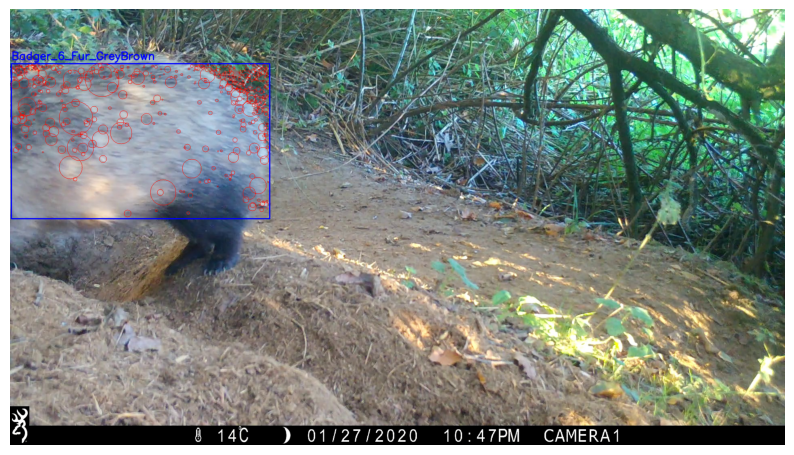

Loaded keypoints for IMG_0006_frame_1680.jpg


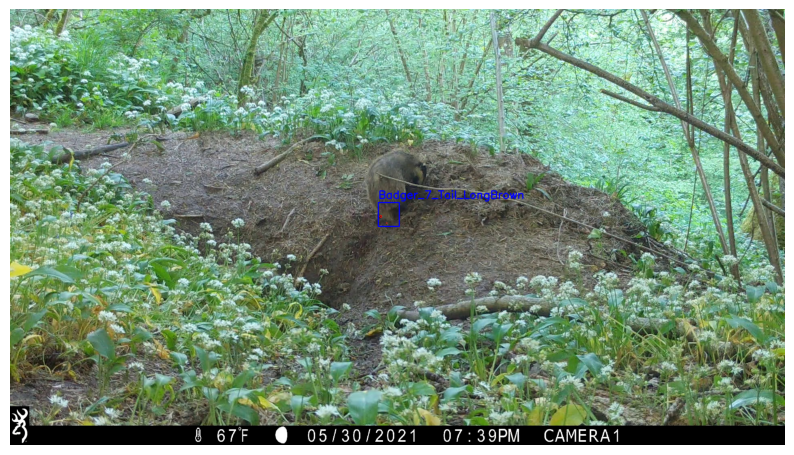

Loaded keypoints for boar_sow_with_cubs_frame_1620.jpg


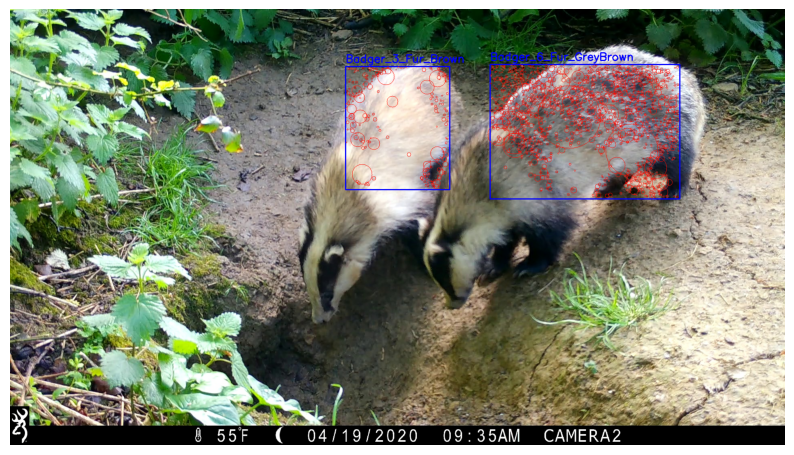

Loaded keypoints for dominate_female_with_cubs_frame_3600.jpg


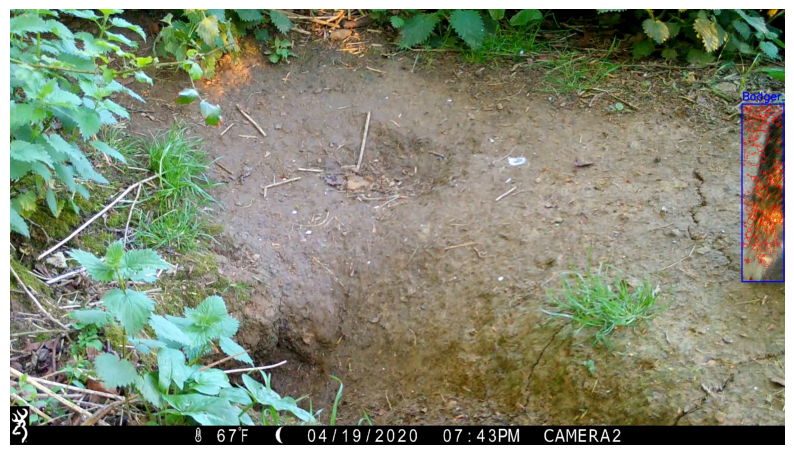

Loaded keypoints for IMG_0083_frame_0.jpg


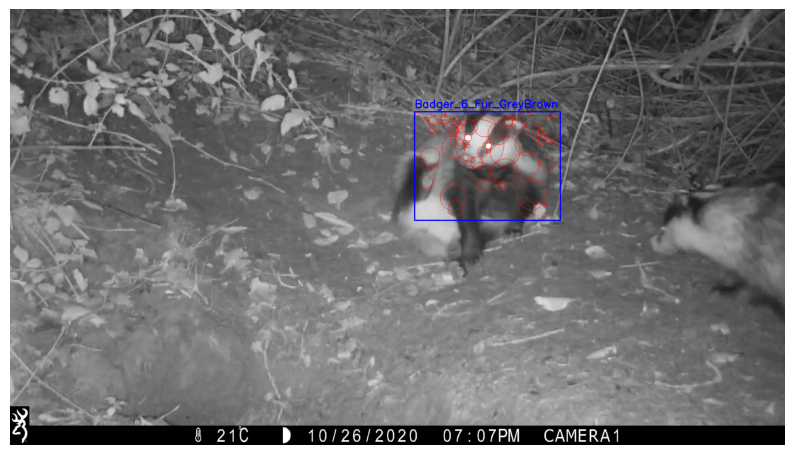

Loaded keypoints for IMG_0003_frame_2400.jpg


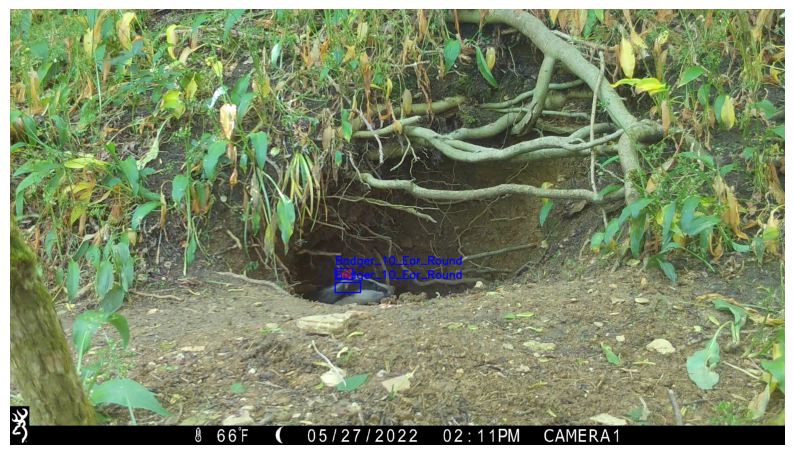

Loaded keypoints for bum_pressing_1_frame_1200.jpg


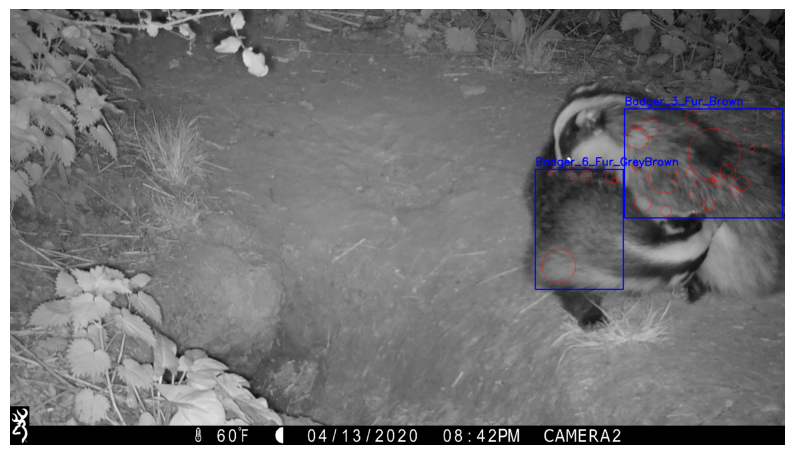

Loaded keypoints for groomin_with_cubs_present_frame_120.jpg


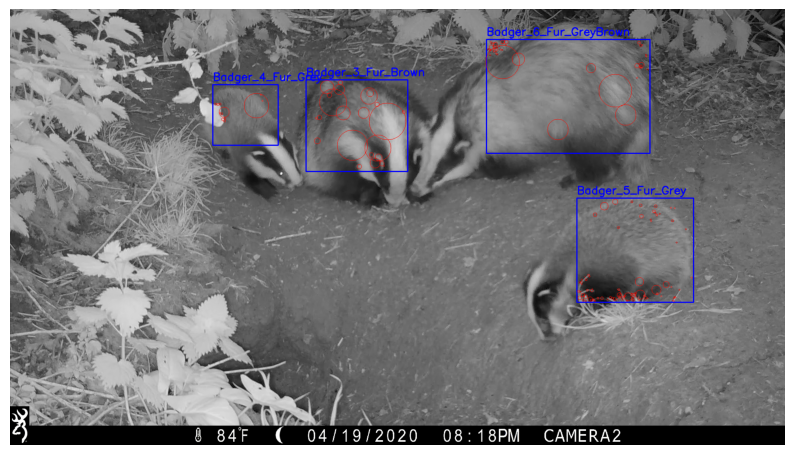

Loaded keypoints for dominate_female_with_cubs_frame_1860.jpg


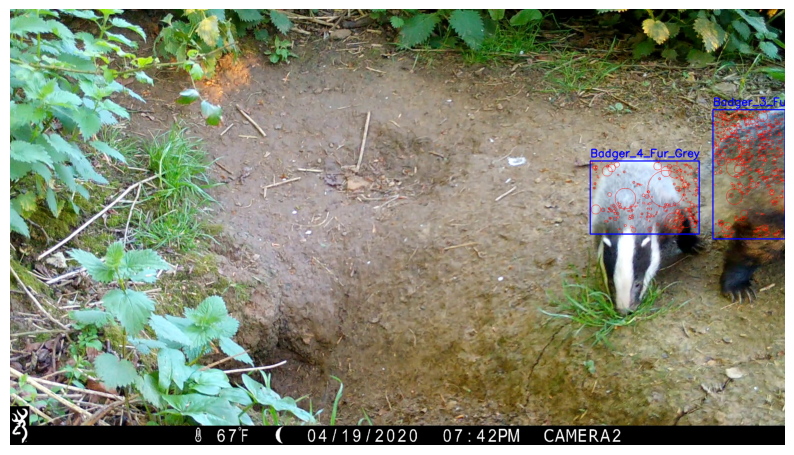

Loaded keypoints for IMG_0014 (2)_frame_240.jpg


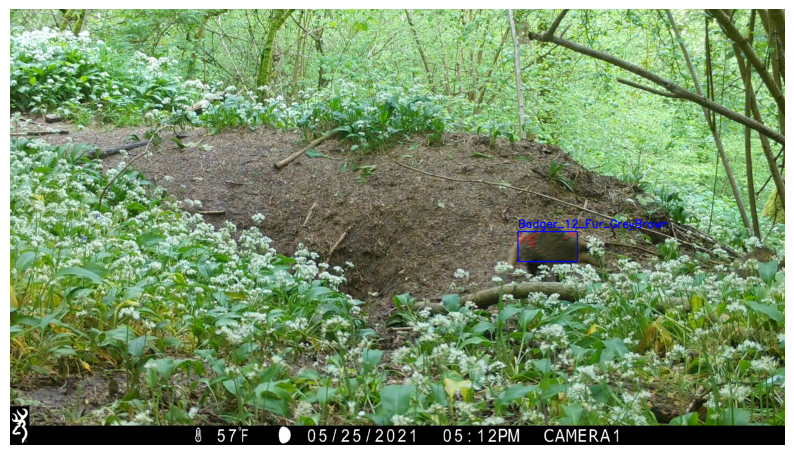

In [ ]:
# load keypoints from JSON file
def load_keypoints(file_path):
    with open(file_path, 'r') as f:
        keypoints_data = json.load(f)
    return keypoints_data

# Paths to the image and keypoints
annotations_dir = '/kaggle/input/project-ai/Annotation2/Annotation2/'
images_dir = '/kaggle/input/project-ai/extracted_frames/extracted_frames/'
keypoints_dir = '/kaggle/working/keypoints_sift/'

# List of keypoints
keypoints_files = [f for f in os.listdir(keypoints_dir) if f.endswith('_keypoints.json')]

# Draw and display keypoints and bounding boxes
for keypoints_file in keypoints_files[15:25]:
    image_file = os.path.splitext(keypoints_file)[0].replace('_keypoints', '') + '.jpg'
    image_path = os.path.join(images_dir, image_file)
    keypoints_path = os.path.join(keypoints_dir, keypoints_file)
    if os.path.exists(image_path):
        keypoints_data = load_keypoints(keypoints_path)
        print(f"Loaded keypoints for {image_file}")
        annotation_file = os.path.splitext(image_file)[0] + '.xml'
        annotation_path = os.path.join(annotations_dir, annotation_file)
        if os.path.exists(annotation_path):
            draw_keypoints_and_bounding_boxes(image_path, annotation_path, keypoints_data)